In [1]:
# Celda 1

import pandas as pd                   # Importa la librería pandas para la manipulación de estructuras de datos (DataFrames)
import numpy as np                    # Importa numpy para operaciones numéricas y manejo de arrays
import matplotlib.pyplot as plt       # Importa matplotlib para la creación de gráficos
import yfinance as yf                 # Importa yfinance para descargar datos financieros desde Yahoo Finance
from statsmodels.tsa.seasonal import seasonal_decompose  # Importa la función para descomponer series de tiempo
from statsmodels.tsa.arima.model import ARIMA            # Importa el modelo ARIMA para análisis y predicción de series
import seaborn as sns  # Seaborn maneja los estilos de Matplotlib
sns.set_style("darkgrid")  # Aplica un estilo de cuadrícula oscura



In [2]:
# Celda 2

# Definimos el símbolo y el rango de fechas para descargar los datos
ticker_symbol = 'AAPL'                # Símbolo de la acción de Apple
start_date = '2020-01-01'             # Fecha de inicio para la descarga de datos
end_date = '2022-12-31'               # Fecha de finalización para la descarga de datos

# Descargamos los datos históricos de AAPL y los almacenamos en un DataFrame
df = yf.download(ticker_symbol, start=start_date, end=end_date)  # Función que descarga los datos de Yahoo Finance

# Mostramos las primeras 5 filas del DataFrame para verificar su contenido
df.head()                             # Imprime las primeras 5 filas del DataFrame


[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2020-01-02,72.716064,72.776591,71.466805,71.721011,135480400
2020-01-03,72.009132,72.771760,71.783977,71.941343,146322800
2020-01-06,72.582901,72.621639,70.876068,71.127858,118387200
2020-01-07,72.241539,72.849216,72.021223,72.592586,108872000
2020-01-08,73.403648,73.706279,71.943759,71.943759,132079200


Columnas del DataFrame: MultiIndex([( 'Close', 'AAPL'),
            (  'High', 'AAPL'),
            (   'Low', 'AAPL'),
            (  'Open', 'AAPL'),
            ('Volume', 'AAPL')],
           names=['Price', 'Ticker'])


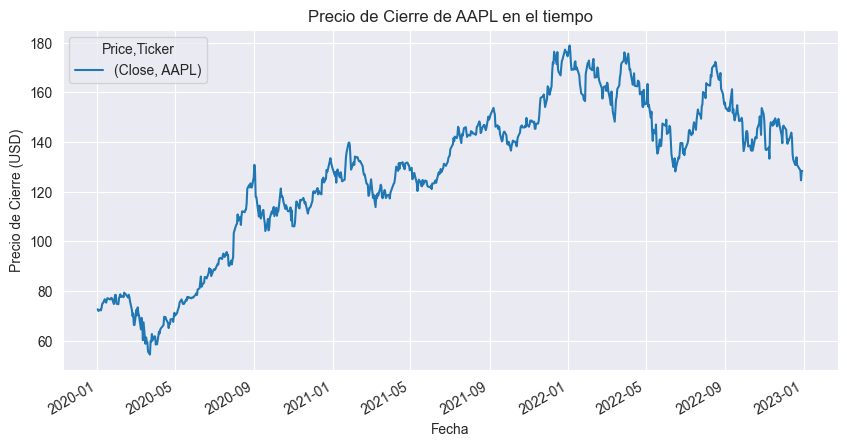

In [3]:
# Celda 3

# Revisamos las columnas disponibles en el DataFrame
print("Columnas del DataFrame:", df.columns)

# Para nuestro análisis, usaremos la columna 'Close' como nuestra serie de tiempo
df_ts = df[['Close']].copy()  # Creamos un nuevo DataFrame solo con la columna 'Close'

# Aseguramos que el índice del DataFrame sea de tipo datetime
df_ts.index = pd.to_datetime(df_ts.index)

# Visualizamos la evolución de la serie en el tiempo
df_ts.plot(figsize=(10, 5))
plt.title('Precio de Cierre de AAPL en el tiempo')
plt.xlabel('Fecha')
plt.ylabel('Precio de Cierre (USD)')
plt.show()


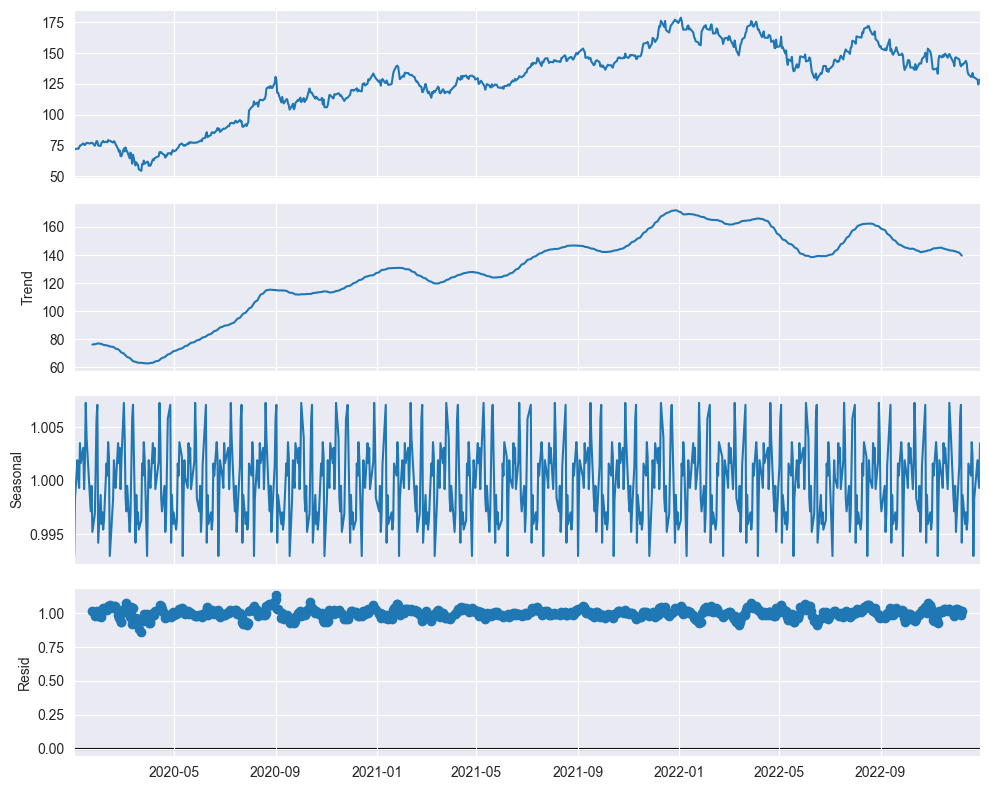

In [4]:
# Celda 4

# Descomponemos la serie para observar tendencia, estacionalidad y residuo
# Notar que este método funciona correctamente en datos con frecuencia y sin valores faltantes
result = seasonal_decompose(df_ts['Close'], model='multiplicative', period=30) 
# "period=30" se usa como ejemplo; en series diarias se suele ajustar según la estacionalidad que se crea relevante

# Graficamos los componentes
fig = result.plot()
fig.set_size_inches(10, 8)
plt.tight_layout()
plt.show()


In [5]:
# Celda 5

# ARIMA requiere una serie estacionaria o casi estacionaria.
# Normalmente, podríamos tomar la diferencia de la serie para estabilizar la media.
# Sin embargo, primero haremos un split (entrenamiento/prueba) para evaluar el rendimiento del modelo.

# Definimos un corte (por ejemplo, en el 80% de los datos)
train_size = int(len(df_ts) * 0.8)  # 80% de los datos para entrenamiento
train_data = df_ts.iloc[:train_size].copy()  # Subconjunto de entrenamiento
test_data = df_ts.iloc[train_size:].copy()   # Subconjunto de prueba

print("Tamaño datos de entrenamiento:", len(train_data))
print("Tamaño datos de prueba:", len(test_data))


Tamaño datos de entrenamiento: 604
Tamaño datos de prueba: 152
